# Test functions for image pre-processing in STED

25/11/2022

Here we want to:
- standardize and normalize images
- remove noise
- segment nuclei
- remove out-of-focus areas

I will use this Jupyter notebook to optimize paramaters. Then I will define functions to treat all images.

## Table of content:
* [Import libraries](#libraries)
* [Pre-process images](#pre-processing)
* [Binary nucleus mask](#mask)
* [Remove out-of-focus areas](#out-of-focus)


---

## Import libraries <a class="anchor" id="libraries"></a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from scipy import ndimage
import numpy as np
import skimage.filters as skfilt
import os
import tifffile

from process import process
from nucmask import nucleus_mask



In [2]:
dirpath = '/Users/christine/Documents/Data/STED/Data_for_analysis/SampleTest'
file = '/Users/christine/Documents/Data/STED/Data_for_analysis/200811_sc-2.tif'

gf_nm = 10 # Gaussian size in nm for denoising



imgname = file.split('/')[-1].split('.')[0]
print(imgname)
condition = imgname.split('_')[-1].split('-')[0]

# Load raw image file and read pixel size from metadata
mABpath = os.path.join(dirpath, imgname+'.msr_414.tif')
POMpath = os.path.join(dirpath, imgname+'.msr_POM.tif')


with tifffile.TiffFile(mABpath) as tif:
    mABraw = tif.pages[0].asarray()  # image as numpy array
    pxs_nm = 1e9/tif.pages[0].tags['XResolution'].value[0]  # pixel size in nm
    print('px size= ',pxs_nm)

with tifffile.TiffFile(POMpath) as tif:
    POMraw = tif.pages[0].asarray()  # image as numpy array
    #print(POMraw.shape)

200811_sc-2
px size=  15.000000150000002


---

## Pre-process images <a class="anchor" id="pre-processing"></a>

This operation encompasses three steps:  
1. Remove outliers (1% quantile) and stretch histogram
2. Normalize image to min-max
3. Apply a gaussian filter to remove noise  


>**Function** process(img, gf_nm=10, pxs_nm=15)
>
>     ***img***      input raw image = greyscale tif image      
>     ***gf_nm***    sigma of the gaussian filter in nm<br>        by default *10nm*      
>     ***pxs_nm***   pixel size in nm<br>         by default *15nm*  
>     
>**returns** smoothed = processed image



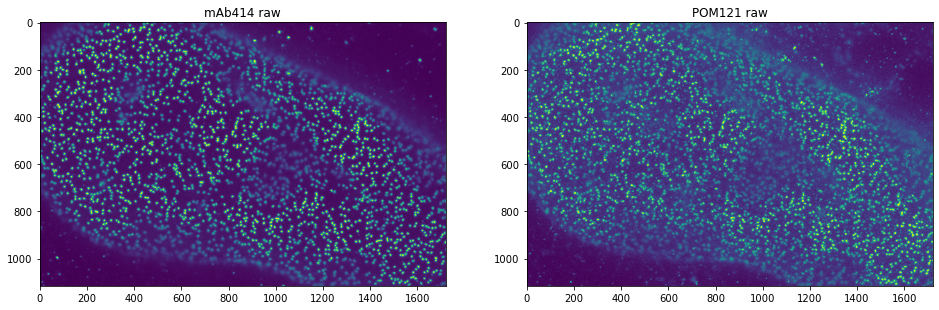

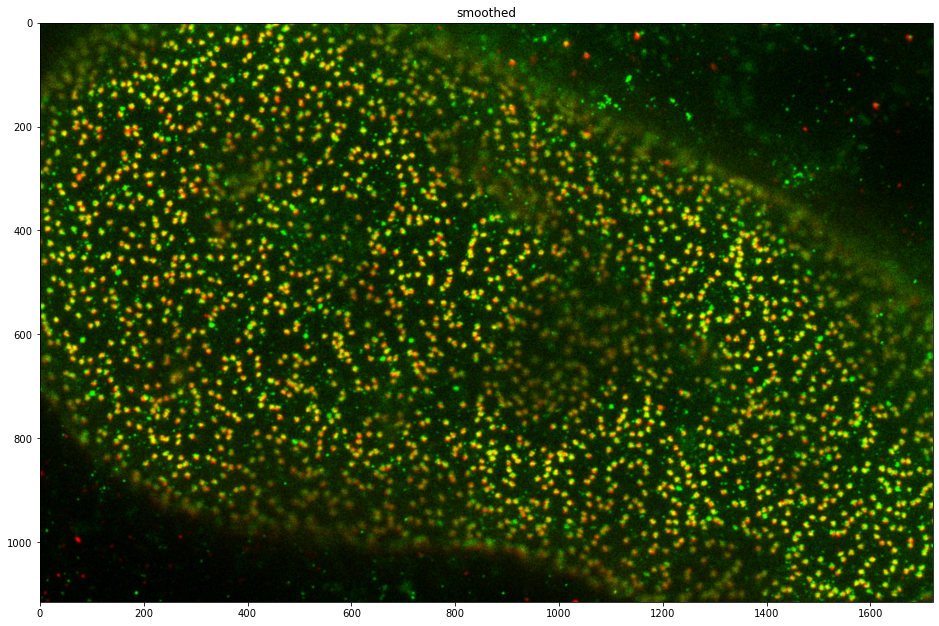

In [3]:

B = np.zeros(POMraw.shape)
RGB_raw = np.dstack((mABraw,POMraw,B)).astype(np.uint8)

def process(img,gf_nm=10,pxs_nm=15):
    ## Standardize
    a = np.quantile(img,0.01)
    b = np.quantile(img,0.99)
    stretch = img
    stretch[img<a]=a
    stretch[img>b]=b

    ## Normalize images (to min/max)
    std = (stretch-np.min(stretch))/(np.max(stretch)-np.min(stretch))

    ## Denoise
    smoothed = ndimage.filters.gaussian_filter(std, sigma=gf_nm/pxs_nm)
    #smoothed = std
    return smoothed

RGB_smoothed = np.dstack((process(mABraw,gf_nm,pxs_nm),process(POMraw,gf_nm,pxs_nm),B))


fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(16,32))
ax0.set_title('mAb414 raw')
ax0.imshow(mABraw)
ax1.set_title('POM121 raw')
ax1.imshow(POMraw)

fig,ax = plt.subplots(figsize=(16,16))
ax.set_title('smoothed')
ax.imshow(RGB_smoothed)

    



---

## Binary nucleus mask <a class="anchor" id="mask"></a>

works better if run on the mAb414 image. Indeed, there is more cytoplasmic background in the POM121 staining => segmentation is less stringent.  

This operation encompasses four steps:
1. applies a gaussian filter to blur the image
2. calculates threshold by the otsu method
3. segments the thresholded image. 
4. applies morphological transformation to refine the mask

>**Function** binary_cell_map(img, gaussstd_nm=300, pxs_nm=15, num_di=0, num_er=0)
>
>     ***img***      input image = greyscale tif image      
>     ***gaussstd_nm***    sigma of the gaussian filter in nm - by default *300nm*      
>     ***pxs_nm***   pixel size in nm - by default *15nm*  
>     ***num_di***   number of dilation - by default *0*  
>     ***num_er***    number of erosion - by default *0*
>     
>**returns** binary = mask



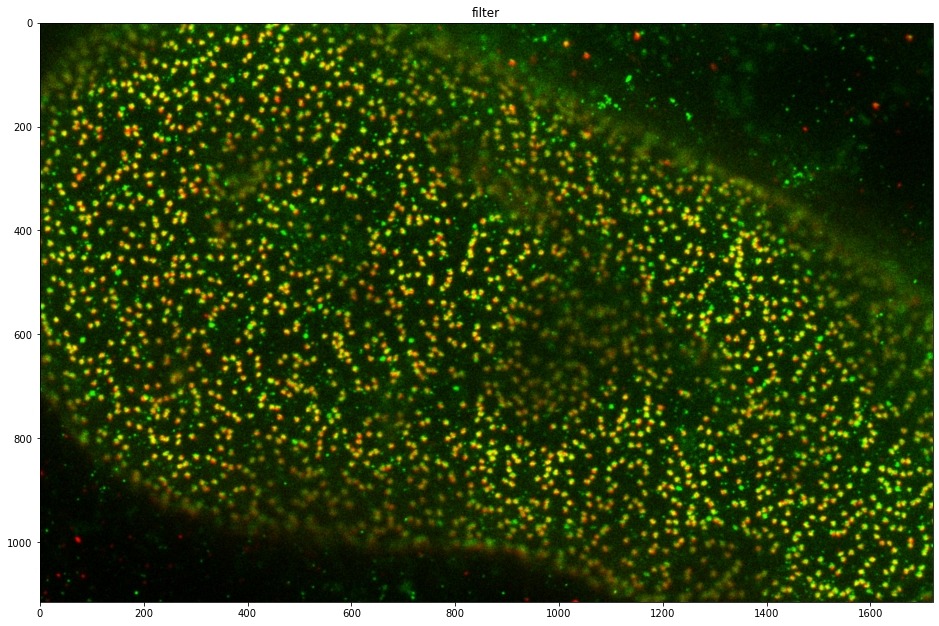

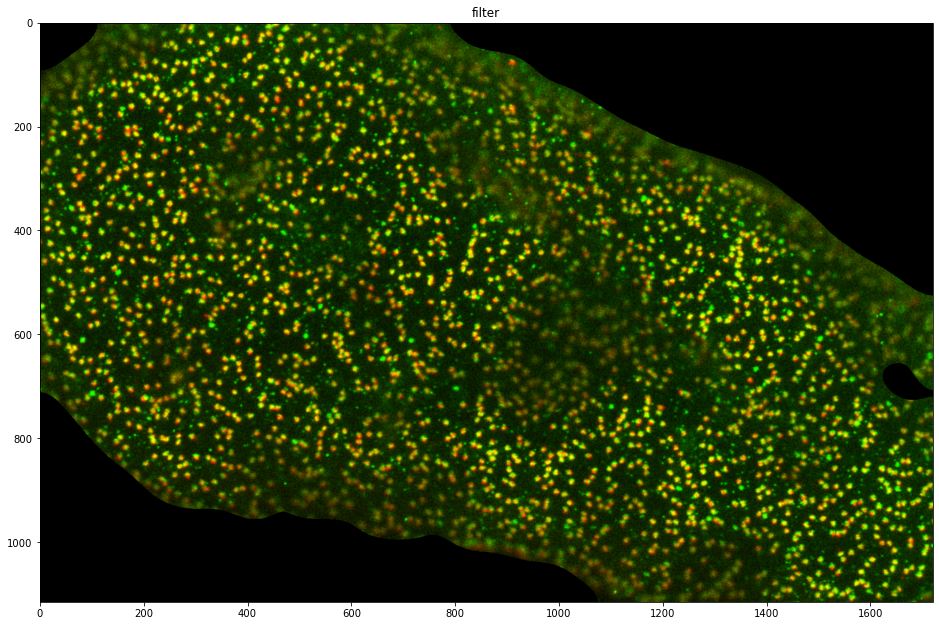

In [4]:
img = process(mABraw,gf_nm,pxs_nm)

def nucleus_mask(img, gaussstd_nm=500, pxs_nm=15, num_di=0, num_er=0):

# gaussian smoothing of the image
    gaussstd = gaussstd_nm/pxs_nm
    img = ndimage.gaussian_filter(img, gaussstd)

    binary = img > skfilt.threshold_otsu(img)+0.015#-np.std(img)
    
    for i in range(0,num_er):
        binary = ndimage.binary_erosion(binary)

    
    
    for i in range(0,num_di):
        binary = ndimage.binary_dilation(binary)
    
    binary = ndimage.binary_fill_holes(binary)

    # remove stray background dots
    binary = morphology.remove_small_objects(binary, 20000)

    return binary



binary = nucleus_mask(img)
img = RGB_smoothed*np.dstack((binary,binary,binary))

fig,ax = plt.subplots(figsize=(16,16))
ax.set_title('filter')
ax.imshow(RGB_smoothed)


fig,ax = plt.subplots(figsize=(16,16))
ax.set_title('filter')
ax.imshow(img)




---

## Remove out-of-focus areas <a class="anchor" id="out-of-focus"></a>

This operation encompasses five steps:
1. applies a low-pass filter to dim out-of-focus areas
2. applies a gaussian filter with wide sigma to blur the image
3. calculates threshold by the otsu method
4. segments the thresholded image. 
5. applies morphological transformation to refine the mask

>**Function** nucleus_focus_mask(img, gaussstd_nm=500, pxs_nm=15, num_di=12, num_er=5,sm_size_nm = 10)
>
>     ***img***      input image = greyscale tif image      
>     ***gaussstd_nm***    sigma for the gaussian blur in nm - by default *500nm* ; it is also the high sigma for the low pass filter     
>     ***pxs_nm***   pixel size in nm - by default *15nm*  
>     ***num_di***   number of dilation - by default *12*  
>     ***num_er***    number of erosion - by default *5*
>     
>**returns** binary = mask



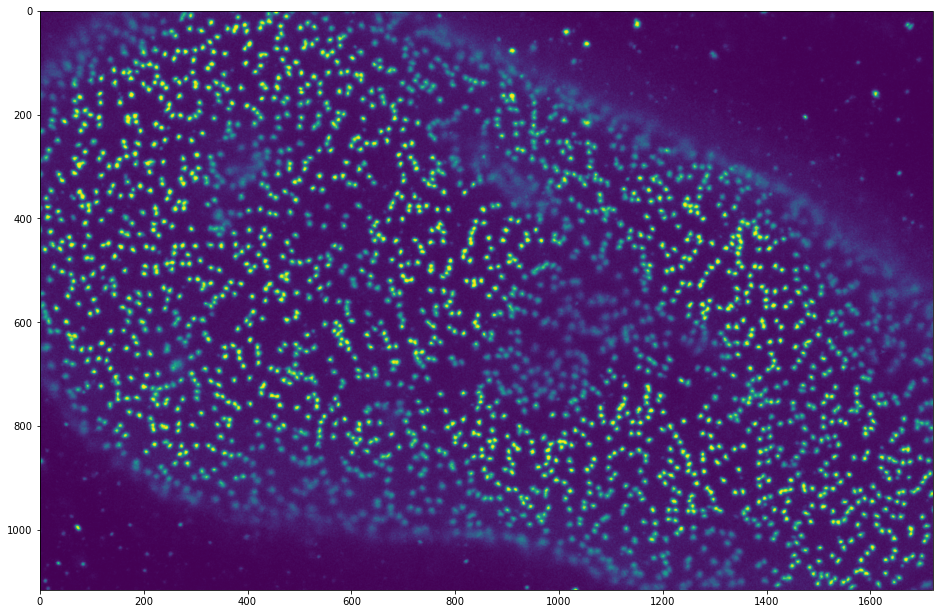

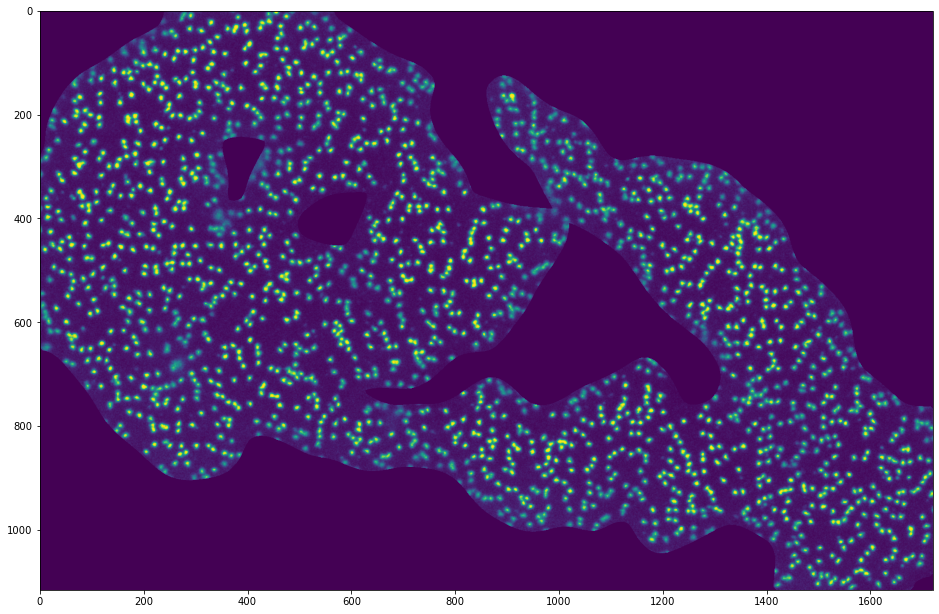

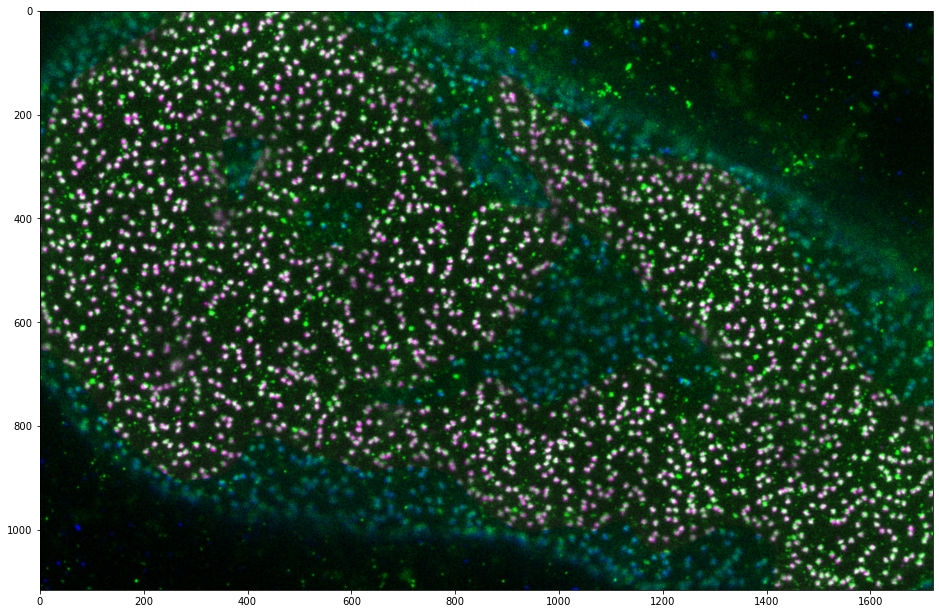

In [44]:
# Preprocess image with a difference of gaussians filter and a gaussian blurring
# take the difference of gaussians to minimize faint out of focus noise
difgaus_sigmahi_nm = 500
sm_size_nm = 10

#img=mABraw



def nucleus_focus_mask(img, gaussstd_nm=500, pxs_nm=15, num_di=12, num_er=5):

# apply low pass filter to decrease out-of-focus contribution
    img = skfilt.difference_of_gaussians(img, low_sigma=0, high_sigma=gaussstd_nm/pxs_nm)
    img[img < 0] = 0  # remove any negative values in the image

# gaussian blurring of the image
    gaussstd = gaussstd_nm/pxs_nm
    img = ndimage.gaussian_filter(img, 1.2*gaussstd)

# thresholding and segmentation
    binary = img > skfilt.threshold_otsu(img)*1.2 #-np.std(img)
    
    for i in range(0,num_er):
        binary = ndimage.binary_erosion(binary)
    
    for i in range(0,num_di):
        binary = ndimage.binary_dilation(binary)
    
# remove stray background dots
    binary = morphology.remove_small_objects(binary, 20000)

    return binary

img = process(mABraw,gf_nm,pxs_nm)
mask = nucleus_focus_mask(img)
img1 = img*mask

fig,ax0 = plt.subplots(figsize=(16,16))
ax0.imshow(img)
fig,ax1 = plt.subplots(figsize=(16,16))
ax1.imshow(img1)


RGB = np.dstack((img1,process(POMraw,gf_nm,pxs_nm),img))

fig,ax4 = plt.subplots(figsize=(16,16))
ax4.imshow(RGB)